# LANET (1.3): Adding Validation Loss

In [0]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import metrics

class standardizer:
  def __init__(self):
      self.row_scale_params = []
      
  def standardize(self, matrix):
    N = matrix.shape[0]
    result = np.empty( matrix.shape )    
    # run through the lines
    for i in range( N ):
      row = matrix[i,:]

      # Compute scaling parameters...
      mean = np.mean(row)
      std = np.std(row)

      # Handle std = 0 case
      if std < 1E-6:
        std = 1

      # and save
      self.row_scale_params.append( [mean, std] )
           
      # add the row to the output
      result[i, :] = np.array( (row - mean) / std  )

    return result

  def check(self, matrix):
    N = matrix.shape[0]
   
    for i in range( N ):
      row = matrix[i,:]

      # Compute scaling parameters...
      mean = np.mean(row)
      std = np.std(row)


def activation(z, act_func):
    global _activation
    if act_func == 'relu':
       return np.maximum(z, np.zeros(z.shape))
    
    elif act_func == 'sigmoid':
      return 1.0/(1.0 + np.exp( -z ))

    elif act_func == 'linear':
        return z
    else:
        raise Exception('Activation function is not defined.')


def get_dactivation(A, act_func):
    if act_func == 'relu':
        return np.maximum(np.sign(A), np.zeros(A.shape)) 

    elif act_func == 'sigmoid':
        h = activation(A, 'sigmoid')
        return h *(1-h)

    elif act_func == 'linear':
        return np.ones(A.shape)

    else:
        raise Exception('Activation function is not defined.')

def loss(y_true, y_predicted, loss_function='mse'):
    if loss_function == 'mse':
      if np.square(y_predicted).sum() > 1E10:
        raise  Exception('Prediction viel zu hoch beim Lernen: {np.square(y_predicted).sum()}')
      return metrics.mean_squared_error( y_true, y_predicted)
    else:
        raise Exception('Loss metric is not defined.')
          


def get_dZ_from_loss(y, y_predicted, metric):
    if metric == 'mse':
        return y_predicted - y
    else:
        raise Exception('Loss metric is not defined.')
   
        
class layer:
  def __init__(self,input_dim, output_dim, activation='relu'):    
    self.activation = activation
    self.input_dim = input_dim
    self.output_dim = output_dim # is this needed?? TODO
    if input_dim > 0:
      self.b = np.ones( (output_dim,1) )       
      self.W = np.ones( (output_dim, input_dim) )
      self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2/input_dim) 
    
    self.A = np.zeros( (output_dim,1) ) # added: we temp. store for A
  
  def setWeight(self, W ):
    self.W = W
    
  def setBias(self, b ):
    self.b = b
    
  def setActivation(self, A ): 
    self.Z =  np.add( np.dot(self.W, A), self.b)
    self.A =  activation(self.Z, self.activation)
  
  
  def print(self, layer_name=""):
    print(f"Layer {layer_name}: Begin of Summary")
    if self.input_dim > 0:
      print(f"Layer {layer_name}: input_dim = {self.input_dim}")
      print(f"Layer {layer_name}: output_dim = {self.output_dim}")
      print(f"Layer {layer_name}: Activation = {self.activation}")
      print(f"W = ")
      print(self.W)
      print(f"A = ")
      print(self.A)
      print(f"b = ")
      print(self.b)
    else:
      print(f"Layer {layer_name}: This is an input layer..... ")
      print(f"A = ")
      print(self.A)
  
    print(f"Layer {layer_name}: End of Summary")
  

class ModelNet:
  def __init__(self, input_dim):  
    self.history = []
    self.neural_net = []
    self.neural_net.append(layer(0 , input_dim, 'irrelevant'))
    

  def addLayer(self, nr_neurons, activation='relu'):    
    layer_index = len(self.neural_net)
    input_dim = self.neural_net[layer_index - 1].output_dim
    new_layer = layer( input_dim, nr_neurons, activation)
    self.neural_net.append( new_layer )
    
  #added  
  def get_history(self):
     return pd.DataFrame(
         self.history, 
         columns=['epoch', 'train_loss', 'val_loss']
     )         

  def forward_propagation(self, input_vec ):
    self.neural_net[0].A = input_vec
    for layer_index in range(1,len(self.neural_net)):    
      _A_Prev = self.neural_net[layer_index-1].A                       
      self.neural_net[layer_index].setActivation( _A_Prev )
      
    return  self.neural_net[layer_index].A
    
    
  def fit(self, input_vec, y_true, max_epoch, val_data, early_stop=1, learning_rate=0.01, verbose=1 ):
    self.learning_rate = learning_rate
    self.history = []  # Reset History Array
    num_train_datum = input_vec.shape[1]
    
    X_val, y_val = val_data
    print(f"Start training for input_vec shape {input_vec.shape} and val_vec {X_val.shape}")
    
     # Training Loop
    for epoch in range(1,max_epoch+1): 

      # Do a forward propagation
      y_val_predicted = self.forward_propagation( X_val )
      y_predicted = self.forward_propagation( input_vec )
      
      #calculate losses
      training_loss = loss(y_true, y_predicted)
      validation_loss = loss( y_val, y_val_predicted)
      
      # Update history
      self.history.append([epoch, training_loss, validation_loss])
 
      # Print before update
      if (verbose > 0):
        print(f"Epoch {epoch}: Y-True = {y_true}")
        print(f"Epoch {epoch}: Y-Pred = {y_predicted}")
        print(f"Epoch {epoch}: Std dev of y pred : {np.std(y_predicted, axis=1)}")
        print(f"Epoch {epoch}: Train.-Loss   = { training_loss  }")
        print(f"Epoch {epoch}: Val-Loss      = { validation_loss  }")
        print(f"Epoch {epoch}: Finished")

      # Learning Step
      self.backward_propagation( y_true, y_predicted,  num_train_datum, verbose = verbose - 1 )

      # Update the weights an biases
      self.update( learning_rate )

      # early stop
      if (epoch > 7)  and (early_stop == 1):
        actual_train_loss = self.history[epoch-1][1] # epochs start with one!
        actual_val_loss   = self.history[epoch-1][2] # epochs start with one!
        past_loss   = self.history[epoch-6][1] 
        if (abs(actual_train_loss - past_loss)) < 1E-3:
          print(f"Early stop in after epoch {epoch} with training-loss  {actual_train_loss}")
          print(f"Early stop in after epoch {epoch} with validation-loss  {actual_val_loss}")          
          print(f"   Prev Loss ({epoch-5}) : {past_loss} [Delta: { abs(actual_train_loss-past_loss) }]")

          break
         
    print(f"Final Epoch {epoch}: Training   Loss = {training_loss}")    
    print(f"Final Epoch {epoch}: Validation Loss = {validation_loss}")    
      
      
  def backward_propagation(self, y, y_predicted, num_train_datum, metric='mse', verbose=0):   
    nr_layers = len(self.neural_net)
    for layer_index in range(nr_layers-1,0,-1):
        if layer_index+1 == nr_layers: # if output layer
            dZ = get_dZ_from_loss(y, y_predicted, metric)
        else: 
            dZ = np.multiply(
                   np.dot(
                       self.neural_net[layer_index+1].W.T, 
                       dZ), 
                   get_dactivation(
                         self.neural_net[layer_index].A, 
                         self.neural_net[layer_index].activation)
                   )
           
        
        dW = np.dot(dZ, self.neural_net[layer_index-1].A.T) / num_train_datum
        db = np.sum(dZ, axis=1, keepdims=True) / num_train_datum
        
        self.neural_net[layer_index].dW = dW
        self.neural_net[layer_index].db = db
        if (verbose > 0):
          print(f"\n\n====== Backward Propagation Layer {layer_index} =======")
          print(f"dZ      =  {dZ}")          
          print(f"dW      =  {dW}")
          print(f"db     =  {db}")
          print(f"A           = {self.neural_net[layer_index].A}") 
          print(f"A prev lay  = {self.neural_net[layer_index-1].A}") 
             
  # added
  def update( self, learning_rate ):
    nr_layers = len(self.neural_net)
    for layer_index in range(1,nr_layers): 
      self.neural_net[layer_index].W = self.neural_net[layer_index].W - learning_rate * self.neural_net[layer_index].dW  
      self.neural_net[layer_index].b = self.neural_net[layer_index].b - learning_rate * self.neural_net[layer_index].db

  def summary(self):
      print("MODEL SUMMARY")
      for layer_index in range(len(self.neural_net)):        
        self.neural_net[layer_index].print(layer_index)
        
      print("FINISHED MODEL SUMMARY")
      


# Testing

## Import the AUTO-MPG Dataloader

In [0]:
def load_auto_mpg_data(samples = -1):
  df = pd.read_csv(
      "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv", 
      na_values=['NA', '?'])


  print( df.describe() )

  # Handle the missing values
  df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

  nCyl = df['cylinders']
  nDis = df['displacement']
  nHor = df['horsepower']
  nWei = df['weight']
  nAcc = df['acceleration']
  nYea = df['year']
  nOri = df['origin']

  X = pd.concat( [nCyl, nDis, nHor, nWei, nAcc, nYea, nOri], axis = 'columns').values;
  y_true = np.array( [ df['mpg'].values ] ) # regression

  if (samples < 0 ):
    return (X.T, y_true)
  else:
    return ( X.T[:, 0:samples], y_true[:, 0:samples])

## Run Test

              mpg   cylinders  ...        year      origin
count  398.000000  398.000000  ...  398.000000  398.000000
mean    23.514573    5.454774  ...   76.010050    1.572864
std      7.815984    1.701004  ...    3.697627    0.802055
min      9.000000    3.000000  ...   70.000000    1.000000
25%     17.500000    4.000000  ...   73.000000    1.000000
50%     23.000000    4.000000  ...   76.000000    1.000000
75%     29.000000    8.000000  ...   79.000000    2.000000
max     46.600000    8.000000  ...   82.000000    3.000000

[8 rows x 8 columns]
(7, 398) (1, 398)
Start training for input_vec shape (7, 79) and val_vec (7, 319)
Final Epoch 200: Training   Loss = 5.855311384670094
Final Epoch 200: Validation Loss = 9.574218998142467


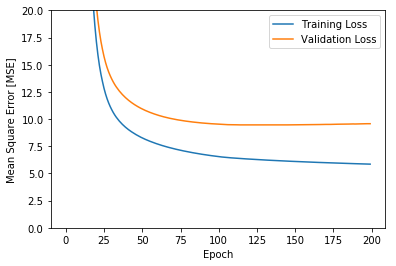

,pred,y
69,19.131015,20.0
70,31.908195,32.4
71,19.305566,19.2
72,25.524429,23.5
73,21.396194,22.4
74,12.622083,12.0
75,31.680120,29.5
76,17.362959,17.5
77,22.762267,28.0
78,11.345250,10.0


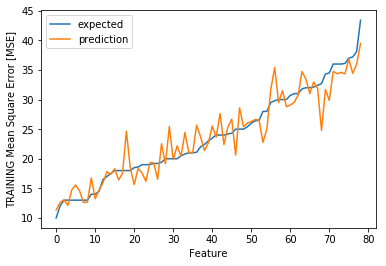

,pred,y
309,13.318671,14.0
310,14.126105,13.0
311,23.851295,26.0
312,12.001395,12.0
313,29.188282,30.5
314,29.537810,26.0
315,33.403952,26.0
316,21.719622,23.0
317,19.905448,21.5
318,31.740162,31.5


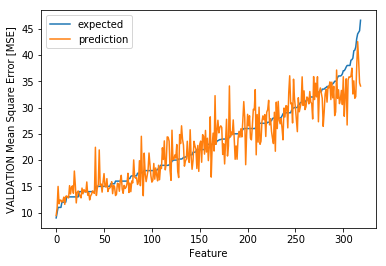

In [0]:
        
#Testing---------------------------------   
_activation = 0     
input_dim = 7
output_dim = 1
model = ModelNet( input_dim )
model.addLayer( 10, 'relu' )
#model.addLayer( 10, 'relu' )
model.addLayer( output_dim, 'linear' )


(X, y_true ) = load_auto_mpg_data()

print( X.shape, y_true.shape)

max_epoch = 200
learning_rate = 0.005

#Scaling
standardizer = standardizer()
X_S = standardizer.standardize( X )

X_train, X_test, y_train, y_test = train_test_split(    
    X_S.T, y_true.T, test_size=0.8)

model.fit( X_train.T, y_train.T, max_epoch, (X_test.T, y_test.T), early_stop=1, learning_rate = learning_rate , verbose=0)
history = model.get_history()

plt.figure()
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [MSE]')
plt.ylim([0,20])  
plt.legend()
plt.show()
      

plt.figure()
t = pd.DataFrame({'pred': model.forward_propagation(X_train.T).flatten() , 'y': y_train.T.flatten()})
display( t.tail(10) )
t.sort_values(by=['y'], inplace=True)
plt.plot(t['y'].tolist(), label='expected')
plt.plot(t['pred'].tolist(), label='prediction')
plt.xlabel('Feature')
plt.ylabel('TRAINING Mean Square Error [MSE]')
plt.legend()
plt.show()


plt.figure()
t = pd.DataFrame({'pred': model.forward_propagation(X_test.T).flatten() , 'y': y_test.T.flatten()})
display( t.tail(10) )
t.sort_values(by=['y'], inplace=True)
plt.plot(t['y'].tolist(), label='expected')
plt.plot(t['pred'].tolist(), label='prediction')
plt.xlabel('Feature')
plt.ylabel('VALDATION Mean Square Error [MSE]')
plt.legend()
plt.show()
